In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [62]:
np.random.seed(0)

In [63]:
train=pd.read_csv("DataSet\Train.csv")
train["Path"]="Dataset/"+train["Path"]
X_trainpath,Y_train=train["Path"],train["ClassId"]

test=pd.read_csv("DataSet\Test.csv")
test["Path"]="Dataset/"+test["Path"]
X_testpath,Y_test=test["Path"],test["ClassId"]

In [64]:
f=open(r"DataSet\Classes.txt")
classes=f.read().split("\n")

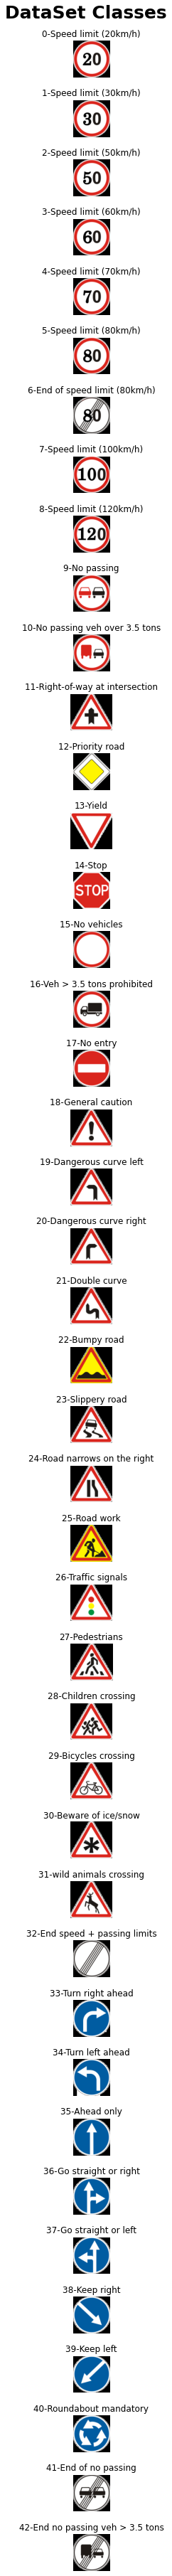

In [71]:
fig,axes=plt.subplots(nrows=43,ncols=1,figsize=(10,50))
fig.tight_layout()
fig.suptitle("DataSet Classes",y=1.01,fontweight="bold",fontsize=25)

for i in range(43):
    path="DataSet\Meta\\"+str(i)+".png"
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"{i}-{classes[i]}")

plt.show()

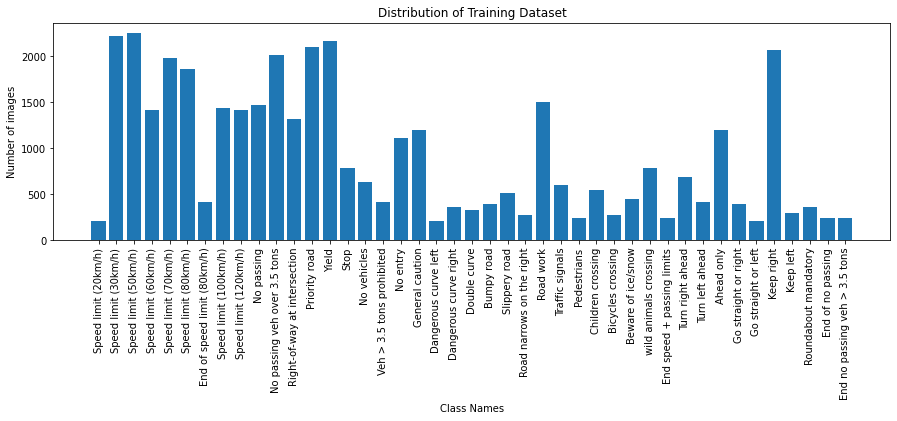

In [66]:
n=[]
for i in range(0,43):
    n.append(len(train[train["ClassId"]==i]))

plt.figure(figsize=(15,4))
plt.bar(classes,n)
plt.title("Distribution of Training Dataset")
plt.xlabel("Class Names")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.show()

In [67]:
def preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.equalizeHist(img)
    img.resize(32,32,1)
    img=img/255
    return img

X_train=np.array(list(map(preprocessing,X_trainpath)),dtype=object)
X_test=np.array(list(map(preprocessing,X_testpath)),dtype=object)

print(X_train.shape)
print(X_test.shape)

(39209, 32, 32, 1)
(12630, 32, 32, 1)


In [69]:
Y_train=to_categorical(Y_train,43)
Y_test=to_categorical(Y_test,43)